# *Libraries*

In [22]:
import os
import tensorflow as tf
from keras.src.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# *Load data*

In [23]:
def load() :
    """Load the images and labels"""
    # Load train data
    train_data = tf.keras.preprocessing.image_dataset_from_directory(
        "../dataset/CNN_Input/train/",
        image_size=(150, 150),
        batch_size=16,
        label_mode='categorical'
    )

    # Load test data
    test_data = tf.keras.preprocessing.image_dataset_from_directory(
        "../dataset/CNN_Input/test/",
        image_size=(150, 150),
        batch_size=16,
        label_mode='categorical'  # Categorical labels for multi-class classification
    )
    return test_data, train_data

# *Plot 8 images*

In [24]:
def plot_img(train_data, class_names):
    """Plot 8 images form a batch"""
    plt.figure(figsize=(8, 5))
    for images, labels in train_data.take(1):  # Take one batch from the dataset
        for i in range(8):
            ax = plt.subplot(2, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[tf.argmax(labels[i]).numpy()])
            plt.axis("off")
        plt.subplots_adjust(hspace=0, wspace=0)
        plt.show()

# *Data preparation*

In [25]:
def normalize_img(train_data, test_data):
    """Normalize the data to have a value between 0 and 1"""
    def normalize(image, label):
        image = image / 255.0  
        return image, label  
        
    # Normalization to both train and test datasets
    train_data_norm = train_data.map(normalize)
    test_data_norm = test_data.map(normalize)

    return test_data_norm, train_data_norm

# *Noise functions*

In [26]:
def add_gaussian_noise(image, label):
    """Adds Gaussian noise to the image."""
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=2.0)
    noisy_image = image + noise
    return noisy_image, label

def add_salt_and_pepper_noise(image, label, salt_prob=0.04, pepper_prob=0.04):
    """Adds salt and pepper noise to the image."""
    # Generate random noise for each pixel
    random_vals = tf.random.uniform(shape=tf.shape(image), minval=0.0, maxval=1.0)
    salt = random_vals < salt_prob
    image = tf.where(salt, 255.0, image)
    
    pepper = random_vals > (1.0 - pepper_prob)
    image = tf.where(pepper, 0.0, image)  # Set selected pixels to 0 (black)
    return image, label  # Return noisy image with its label
    

# *Build and Compile CNN*

In [27]:
# Build the CNN model for multi-class classification
def build_cnn_model():
    """Build the CNN model"""
    model = models.Sequential([
        layers.InputLayer(shape=(150, 150, 3)),  # Input shape (150x150x3)
        
        # Convolutional layers with max pooling
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=(2, 2)),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=(2, 2)),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=(2, 2)),
        layers.MaxPooling2D((2, 2)),
        
        # Flatten the output and pass through dense layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(4, activation='softmax')  # 4 output units, one for each class (good, bad, contaminated, etc.)
    ])
    
    # Compile the model with sparse categorical crossentropy loss
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# *Train model*

In [28]:
# Stop training early if no improvement in validation loss for 5 epochs

def train_model(model, train_data_norm, test_data_norm):
    """Train the model"""
    callbacks = [  
        # Stop training early if no improvement in validation loss for 5 epochs
         EarlyStopping(
            monitor='val_loss', 
            patience=5, 
            restore_best_weights=True
        ),
        # Reduce learning rate if validation loss plateaus
        ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.2,
            patience=3 
        )
    ]
    
    history = model.fit(
        train_data_norm,
        epochs=70,
        validation_data=test_data_norm,
        callbacks=callbacks
    )
    return history

# *Plotting Training and Validation Figures*

In [29]:
def plot_metrics(history): # Insert parameter name
    """Plot metrics of the CNN"""
    # Plot traning and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot traning and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

# *Main*

Found 83 files belonging to 4 classes.
Found 62 files belonging to 4 classes.
Normal images


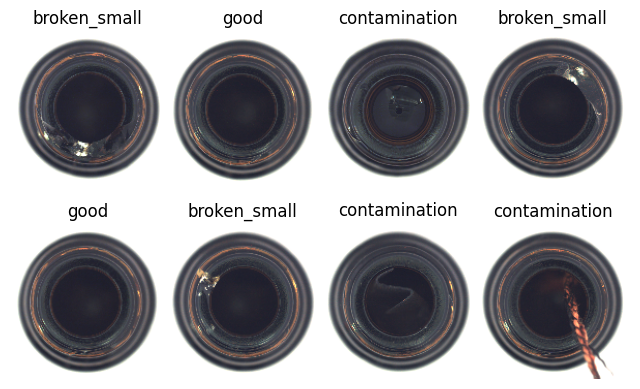

Gaussian noise images


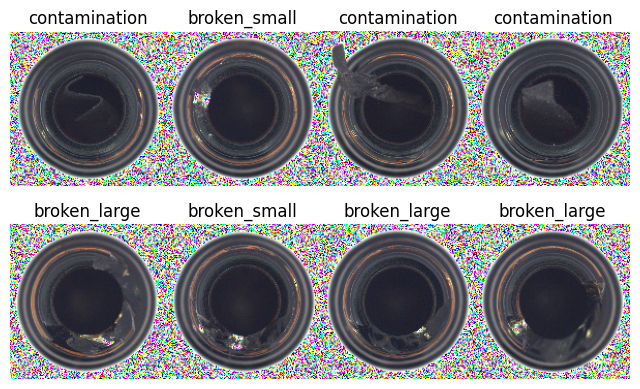

Salt & Pepper noise images


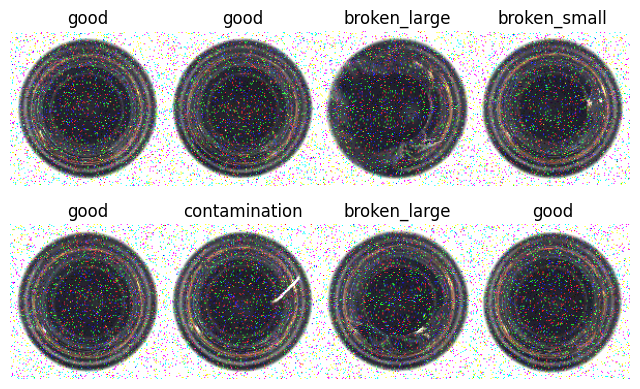

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 75, 75, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 19, 19, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 5, 5, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,428 (622.77 KB)

 Trainable params: 159,428 (622.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.2213 - loss: 1.4140 - val_accuracy: 0.2742 - val_loss: 1.3843 - learning_rate: 0.0010
Epoch 2/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.2757 - loss: 1.3857 - val_accuracy: 0.4194 - val_loss: 1.3845 - learning_rate: 0.0010
Epoch 3/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.3229 - loss: 1.3831 - val_accuracy: 0.3145 - val_loss: 1.3798 - learning_rate: 0.0010
Epoch 4/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.2543 - loss: 1.3838 - val_accuracy: 0.3387 - val_loss: 1.3800 - learning_rate: 0.0010
Epoch 5/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.2904 - loss: 1.3777 - val_accuracy: 0.3952 - val_loss: 1.3582 - learning_rate: 0.0010
Epoch 6/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.4385 - loss: 1.3481 - val_accuracy: 0.2661 - val_loss: 1.3384 - learning_rate: 0.0010
Epoch 7/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.3715 - loss: 1.3169 - v

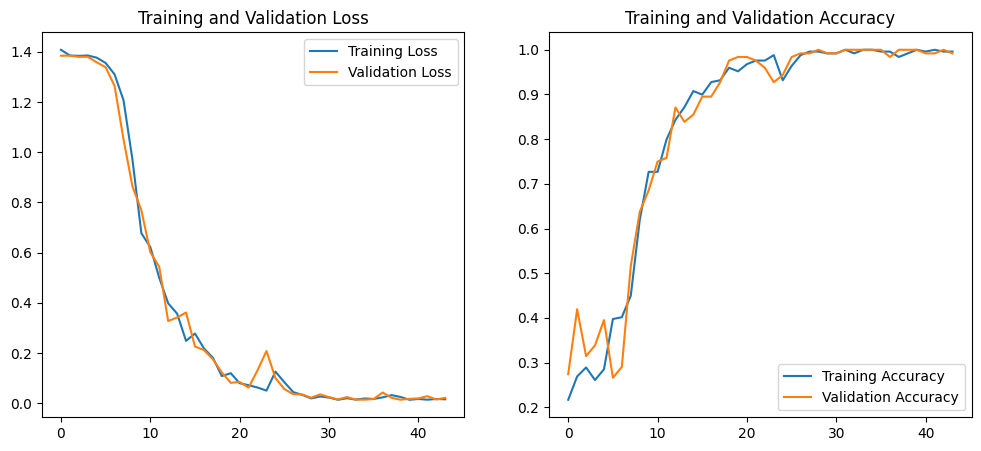

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.9918 - loss: 0.0172
Test Loss: 0.029187722131609917
Test Accuracy: 98.39%
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
Classification Report:
               precision    recall  f1-score   support

 broken_large       0.14      0.14      0.14        28
 broken_small       0.26      0.26      0.26        34
contamination       0.32      0.31      0.32        32
         good       0.13      0.13      0.13        30

     accuracy                           0.22       124
    macro avg       0.21      0.21      0.21       124
 weighted avg       0.22      0.22      0.22       124

Confusion Matrix:
[[ 4  7  7 10]
 [ 7  9  6 12]
 [ 8  9 10  5]
 [ 9  9  8  4]]


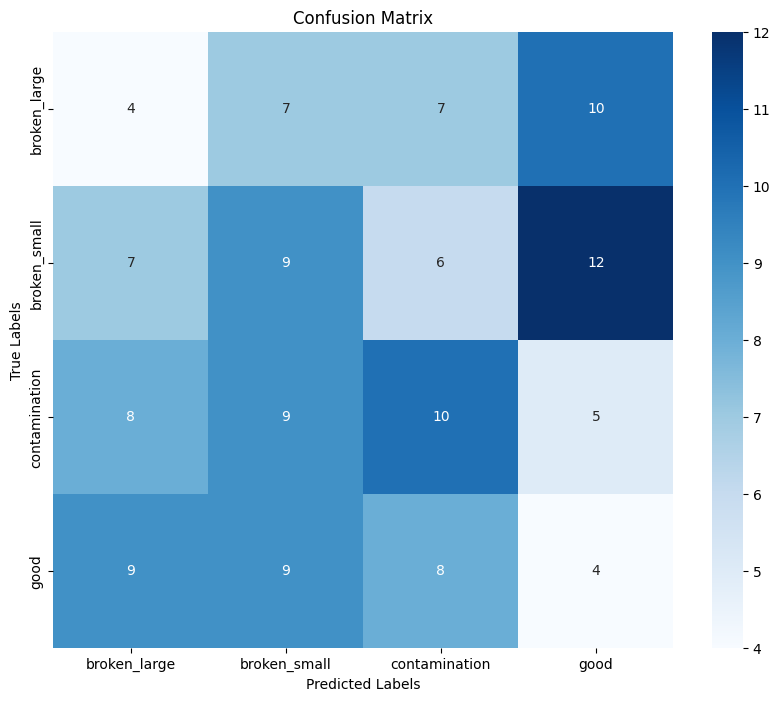

In [30]:
test_data, train_data = load()
class_names = train_data.class_names

g_noisy_train_data = train_data.map(add_gaussian_noise)
snp_noisy_train_data = train_data.map(add_salt_and_pepper_noise)

combined_train_data = train_data.concatenate(g_noisy_train_data).concatenate(snp_noisy_train_data)

print("Normal images")
plot_img(train_data, class_names)
print("Gaussian noise images")
plot_img(g_noisy_train_data, class_names)
print("Salt & Pepper noise images")
plot_img(snp_noisy_train_data, class_names)

percentage_noisy_images = 0.2
total_test_images = len(test_data) * 16  # Total images in test data
num_noisy_images = int(total_test_images * percentage_noisy_images)

g_noisy_test_data = test_data.take(num_noisy_images).map(add_gaussian_noise)
snp_noisy_test_data = test_data.take(num_noisy_images).map(add_salt_and_pepper_noise)

remaining_test_data = test_data.skip(num_noisy_images)
combined_test_data = g_noisy_test_data.concatenate(remaining_test_data)
combined_test_data = combined_test_data.concatenate(snp_noisy_test_data)

test_data_norm, train_data_norm = normalize_img(combined_train_data, combined_test_data)
model = build_cnn_model()
model.summary()
history = train_model(model, train_data_norm, test_data_norm)
plot_metrics(history)

test_loss, test_accuracy = model.evaluate(test_data_norm)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_pred_prob = model.predict(test_data_norm)
y_pred = np.argmax(y_pred_prob, axis=1)

y_true = np.concatenate([y for x, y in test_data_norm], axis=0)  # Hämtar etiketter
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)  # Konvertera till klassindex

report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)



In [ ]:
all_images = []
all_labels = []

for images, labels in test_data_norm:
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

all_images_np = np.concatenate(all_images, axis=0)
all_labels_np = np.concatenate(all_labels, axis=0)

print("Shape of all images:", all_images_np.shape)
print("Shape of all labels:", all_labels_np.shape)

print(all_labels_np)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(all_labels_np, axis=1)

print(y_pred_classes)
print(y_true_classes)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Heatmap")
plt.show()